# ASPIRE ab initio pipeline -- simulated data -- comparison with JaxEM

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import jax.numpy as jnp
import mrcfile
import logging
from  matplotlib import pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"]=6,6

In [2]:
from src.projection import project_spatial
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.utils import *
from src.aspire_interface import get_params_from_aspire

from aspire.abinitio import CLSyncVoting
from aspire.basis import FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)

### Parameters

In [3]:
interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 1000  # How many images in our source.
n_classes = 100  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
#noise_variance = 5e-7  # Set a target noise variance
noise_variance = 1e-5
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True

### Simulation data

In [4]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"

og_v = Volume.load(vol_file, dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

2022-06-21 12:44:19,106 INFO /home/bt387/project/simple_cryoem/data/emdb/emd_2660.map with dtype float32 loaded as <class 'numpy.float64'>
2022-06-21 12:44:19,217 INFO Original volume map data shape: (1, 360, 360, 360) dtype:float64


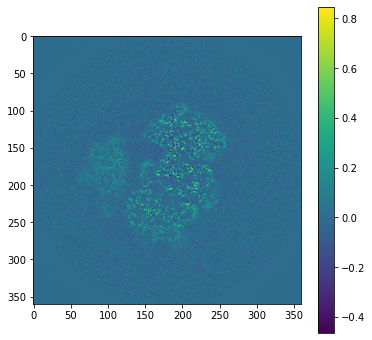

In [5]:
plt.imshow(og_v[0,180]); plt.colorbar()

In [6]:
logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution

2022-06-21 12:44:19,466 INFO Downsampling to (32, 32, 32)


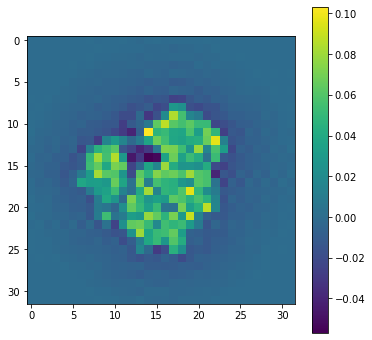

In [7]:
plt.imshow(v[0,16]); plt.colorbar()

In [8]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v.mrc', overwrite=True) as mrc:
        mrc.set_data(og_v._data.astype(np.float32))

In [9]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

In [10]:
# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise_filter = FunctionFilter(noise_function)

In [11]:
logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]



2022-06-21 12:44:27,984 INFO Initialize CTF filters.


2022-06-21 12:44:28,015 INFO Creating Simulation with 1000 images.
2022-06-21 12:44:28,017 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-21 12:44:28,033 INFO Creating Simulation with 1000 images.
2022-06-21 12:44:28,035 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-21 12:44:28,051 INFO Appending a NoiseAdder to generation pipeline
2022-06-21 12:44:28,053 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:28,054 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:28,055 INFO Trying NFFT backend finufft
2022-06-21 12:44:28,060 INFO NFFT backend finufft usable.
2022-06-21 12:44:28,060 INFO Trying NFFT backend cufinufft
2022-06-21 12:44:28,062 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2022-06-21 12:44:2

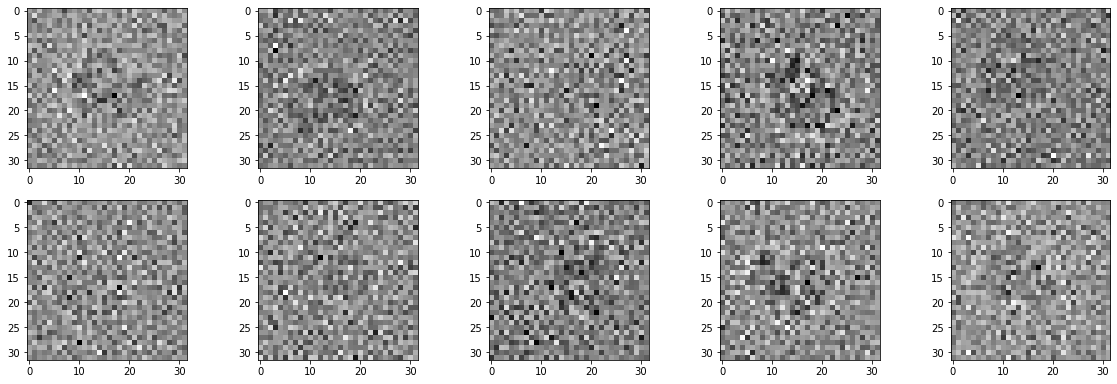

In [12]:
# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)

angles = src.angles
shifts = src.offsets

angles[0] = [0,0,0]
shifts[0] = [0,0]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= custom_noise_filter,
    unique_filters= ctf_filters,
)
# Peek
if interactive:
    src.images(0, 10).show()

In [13]:
# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
#src.phase_flip()


2022-06-21 12:44:28,952 INFO Perform phase flip to input images.


In [14]:
# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
#src.whiten(aiso_noise_estimator.filter)

2022-06-21 12:44:28,983 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:28,992 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:30,564 INFO Applying forward transformations in pipeline
2022-06-21 12:44:30,567 INFO All forward transformations applied
2022-06-21 12:44:30,568 INFO Loaded 512 images
2022-06-21 12:44:30,577 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:30,581 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:32,049 INFO Applying forward transformations in pipeline
2022-06-21 12:44:32,050 INFO All forward transformations applied
2022-06-21 12:44:32,050 INFO Loaded 488 images


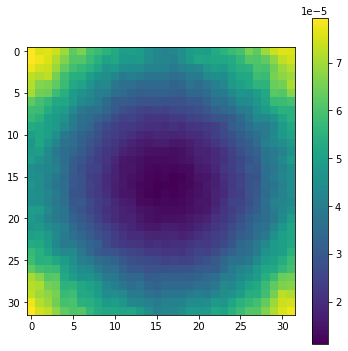

2022-06-21 12:44:32,219 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:32,221 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:32,282 INFO Applying forward transformations in pipeline
2022-06-21 12:44:32,284 INFO All forward transformations applied
2022-06-21 12:44:32,285 INFO Loaded 10 images


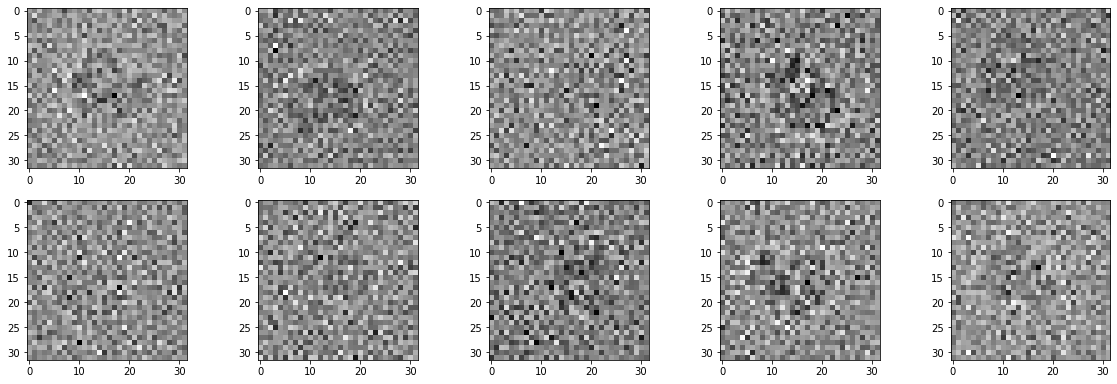

In [15]:
# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.colorbar()
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images(0, 10).show()

In [16]:
# Cache to memory for some speedup
src.cache()

2022-06-21 12:44:32,867 INFO Caching source images
2022-06-21 12:44:32,869 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:32,878 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:35,798 INFO Applying forward transformations in pipeline
2022-06-21 12:44:35,801 INFO All forward transformations applied
2022-06-21 12:44:35,802 INFO Loaded 1000 images


### Class Averaging

In [ ]:
logging.disable(logging.INFO)

In [ ]:
logger.info("Begin Class Averaging")

rir = RIRClass2D(
    src,  # Source used for classification
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=n_nbor,
    n_classes=n_classes,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    averager=None,
)

classes, reflections, distances = rir.classify()
avgs = rir.averages(classes, reflections, distances)
if interactive:
    avgs.images(0, 10).show()

### Common Line Estimation

In [ ]:
logger.info("Begin Orientation Estimation")

# Stash true rotations for later comparison,
#   note this line only works with naive class selection...
true_rotations = src.rots[:n_classes]

orient_est = CLSyncVoting(avgs, n_theta=36)
# Get the estimated rotations
orient_est.estimate_rotations()
rots_est = orient_est.rotations

logger.info("Compare with known rotations")
# Compare with known true rotations
Q_mat, flag = register_rotations(rots_est, true_rotations)
regrot = get_aligned_rotations(rots_est, Q_mat, flag)
mse_reg = get_rots_mse(regrot, true_rotations)
logger.info(
    f"MSE deviation of the estimated rotations using register_rotations : {mse_reg}\n"
)

### Volume reconstruction

In [ ]:
logger.info("Begin Volume reconstruction")

# Assign the estimated rotations to the class averages
avgs.rots = rots_est

# Create a reasonable Basis for the 3d Volume
basis = FFBBasis3D((v.resolution,) * 3, dtype=v.dtype)

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(avgs, basis)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()
fn = f"{out_dir}/estimated_volume_n{num_imgs}_c{n_classes}_m{n_nbor}_{img_size}.mrc"
estimated_volume.save(fn, overwrite=True)

# Peek at result
if interactive:
    plt.imshow(np.sum(estimated_volume[0], axis=-1))
    plt.show()

In [ ]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_aspire.mrc', overwrite=True) as mrc:
        mrc.set_data(estimated_volume._data.astype(np.float32))

### Aspire vs JaxEM

Text(0.5, 1.0, 'Volume_comp MIP')

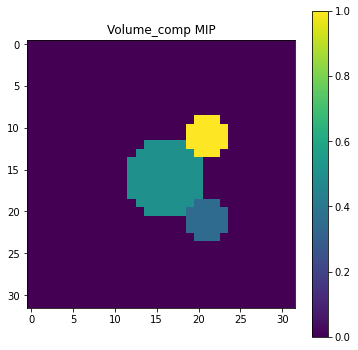

In [17]:
nx = img_size
shape = np.array([nx,nx,nx])
dimensions = pixel_size * shape

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]]) * 500
radii = np.array([0.1, 0.05, 0.05]) * 500
intensities = np.array([10,7,20])

myv = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.1))
mip_z(myv)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

### Compare for specific angles/shifts/ctf_params 

In [18]:
angles = np.array(angles)
shifts = np.array(shifts)

angles[0] = [jnp.pi/6,jnp.pi/4, jnp.pi/2]
shifts[0] = [-5.4, 6.8]

v._data = np.array([myv])

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()

N = 1
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)
imgs = jnp.array(src.images(0,N).data)
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
shifts = src.offsets

print(f"x_grid = {x_grid}")

2022-06-21 12:44:36,549 INFO Creating Simulation with 1000 images.
2022-06-21 12:44:36,551 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-21 12:44:36,565 INFO Perform phase flip on source object
2022-06-21 12:44:36,566 INFO Adding Phase Flip Xform to end of generation pipeline
2022-06-21 12:44:37,406 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:37,409 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:37,440 INFO Applying forward transformations in pipeline
2022-06-21 12:44:37,440 INFO   Applying IndexedXform
2022-06-21 12:44:37,442 INFO All forward transformations applied
2022-06-21 12:44:37,443 INFO Loaded 1 images
x_grid = [3.07692308e-03 3.20000000e+01]


In [19]:
angles[0]

array([0.5235988, 0.7853982, 1.5707964], dtype=float32)

In [20]:
myshifts = jnp.array([shifts[0,1], shifts[0,0]]) * pixel_size # This seems correct
myangles = -jnp.array([angles[0,2], angles[0,1], angles[0,0]])
myctf_params = jnp.array(
    [jnp.array([f.defocus_u, f.defocus_v, f.defocus_ang, 0, f.voltage, f.alpha, f.Cs, 0, 2*pixel_size]) for f in ctf_filters]
)[0]

Text(0.5, 1.0, 'my projection')

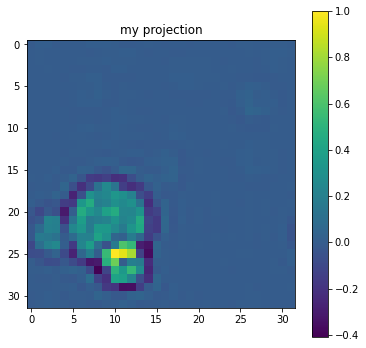

In [21]:
pr = project_spatial(vol, myangles, pixel_size, myshifts, ctf_params= myctf_params)
pr = pr/jnp.max(pr)
plt.imshow(pr); plt.colorbar()
plt.title('my projection')

Text(0.5, 1.0, 'aspire')

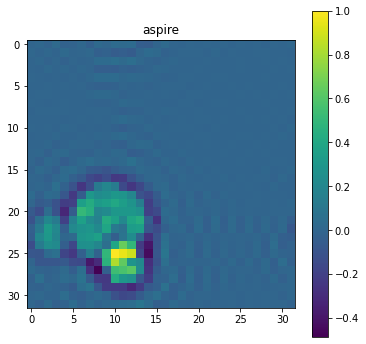

In [22]:
pr_a = imgs[0] /jnp.max(imgs[0])
plt.imshow(pr_a); plt.colorbar()
plt.title('aspire')

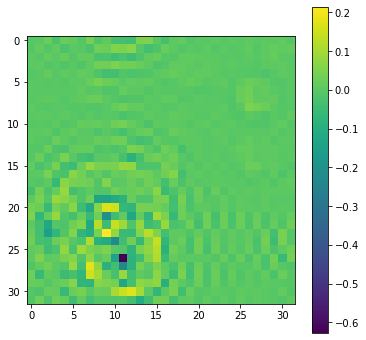

In [23]:
plt.imshow(pr-pr_a); plt.colorbar()

### Compare for many images

In [24]:
@jax.jit
def calc_img_err(img1, img2, mask):
    img1 = jnp.fft.fftshift(img1*mask)
    img1 = img1/jnp.max(jnp.abs(img1))
    
    img2 = jnp.fft.fftshift(img2*mask)
    img2 = img2/jnp.max(jnp.abs(img2))
    
    return jnp.mean(jnp.abs(img1-img2))

calc_img_err_vmap = jax.vmap(calc_img_err, in_axes = (0,0,None))

In [25]:
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()

vol = jnp.array(v._data[0])
vol_f, _, _ = volume_fourier(v._data[0], pixel_size)

2022-06-21 12:44:51,814 INFO Creating Simulation with 1000 images.
2022-06-21 12:44:51,816 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-21 12:44:51,831 INFO Perform phase flip on source object
2022-06-21 12:44:51,833 INFO Adding Phase Flip Xform to end of generation pipeline


In [26]:
imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params, x_grid, mask = get_params_from_aspire(src, pixel_size)
slice_obj = Slice(x_grid, mask)
imgs_f = slice_obj.slice_array(vol_f, angles, shifts, ctf_params).reshape([-1, nx,nx])

2022-06-21 12:44:51,875 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:44:51,884 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:44:52,296 INFO Applying forward transformations in pipeline
2022-06-21 12:44:52,297 INFO   Applying IndexedXform
2022-06-21 12:44:52,328 INFO All forward transformations applied
2022-06-21 12:44:52,329 INFO Loaded 1000 images


In [27]:
errs = calc_img_err_vmap(imgs_f, imgs_f_aspire, mask)
print(f"errs.shape = {errs.shape}")
print(f"jnp.max(errs) = {jnp.max(errs)}")

errs.shape = (1000,)
jnp.max(errs) = 0.04010748409904889


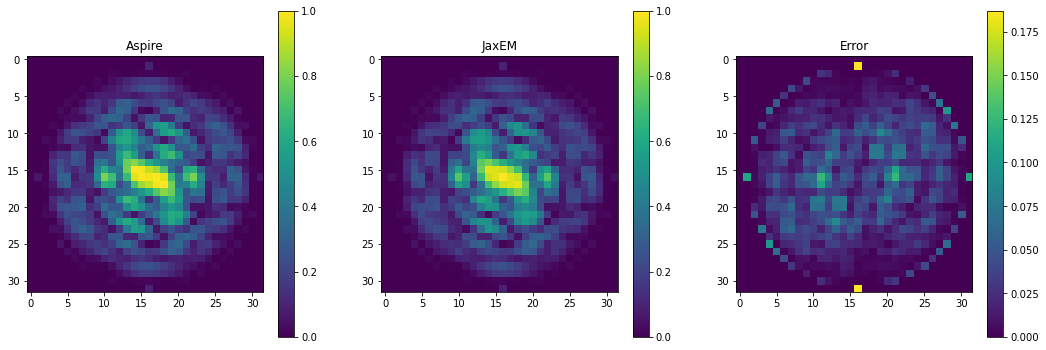

In [28]:
imgidx = 13

img1 = jnp.fft.fftshift(imgs_f_aspire[imgidx]*mask)
img1 = img1/jnp.max(jnp.abs(img1))

img2 = jnp.fft.fftshift(imgs_f[imgidx]*mask)
img2 = img2/jnp.max(jnp.abs(img2))

err_f = jnp.abs(img1-img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(jnp.abs(img1))
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(jnp.abs(img2))
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(err_f)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

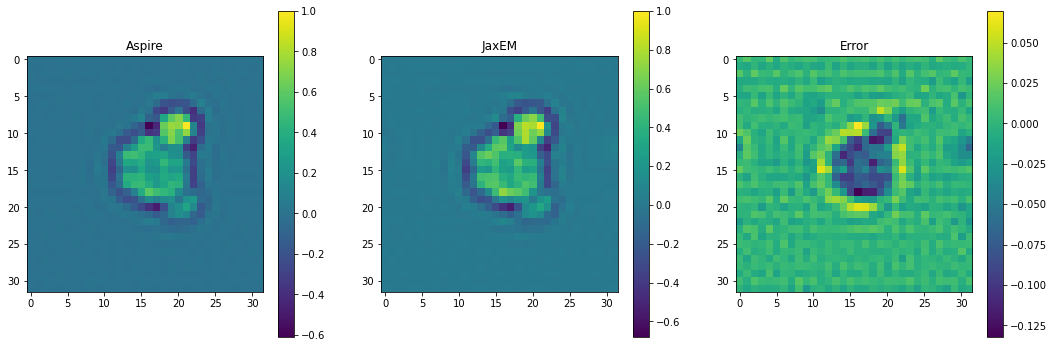

In [30]:
img1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f_aspire[imgidx]*mask)))
img1 = img1/jnp.max(img1)

img2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f[imgidx]*mask)))
img2 = img2/jnp.max(img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(img1)
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(img2)
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(img1-img2)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6